In [1]:
import torch
import numpy as np
import matplotlib as mp
import torch.nn as nn
import torch.nn.functional as F

# LeNet
Now let's implement the classic LeNet architecture- http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

class LeNet(nn.Module):
    def __init__(self, num_classes=10):  # MNIST has 10 classes
        super(LeNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(400, 120)  # 4*4 is the size of the image after convolutions and pooling
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



# MNIST 
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # 32x32 input
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # MNIST is grayscale, single channel
])


trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


model = LeNet(num_classes=10)  #  10 classes in MNIST

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


100%|██████████| 9912422/9912422 [00:00<00:00, 118720923.49it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39522249.21it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 87137024.95it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 10037159.52it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
type(transform)

torchvision.transforms.transforms.Compose

In [4]:
# First, let's make sure the model is in evaluation mode
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        # Forward pass
        outputs = model(images)

        # predictions from maximum
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the 10000 test images: {accuracy:.2f}%')


Accuracy of the model on the 10000 test images: 13.70%


# Pre-trained VGG
Essentially state of the art model

In [14]:
import torch
import torchvision.models as models
from tqdm import tqdm


# MNIST
transform = transforms.Compose([
    transforms.Resize(224),  # Resize to 224x224 pixels
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize for MNIST data
])



trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)




# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 10)
vgg16.eval()
vgg16.cuda()



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
# Fine-tuning
import torch.optim as optim
import torch.nn.functional as F


# Loss function + optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.0001)
vgg16.cuda()

is_cuda_available = torch.cuda.is_available()

num_epochs = 3  # Number of epochs
for epoch in range(num_epochs):
    vgg16.train()  # Set the model to training mode
    for images, labels in tqdm(trainloader):
        if is_cuda_available:
            images, labels = images.cuda(), labels.cuda()

        # Zero out
        optimizer.zero_grad()

        # Forward pass
        outputs = vgg16(images)

        # Calculate loss
        loss = loss_fn(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")



100%|██████████| 938/938 [04:14<00:00,  3.69it/s]


Epoch [1/53], Loss: 0.0005


100%|██████████| 938/938 [04:12<00:00,  3.71it/s]


Epoch [2/53], Loss: 0.0012


100%|██████████| 938/938 [04:17<00:00,  3.64it/s]


Epoch [3/53], Loss: 0.0024


  4%|▎         | 34/938 [00:09<04:06,  3.66it/s]


KeyboardInterrupt: 

Note: the model's loss was increasing! Not what we want to see

In [21]:
# Testing
vgg16.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(testloader):
        # Forward pass
        outputs = vgg16(images.cuda())

        # predictions from maximum
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the 10000 test images: {accuracy:.2f}%')


100%|██████████| 157/157 [00:32<00:00,  4.84it/s]

Accuracy of the model on the 10000 test images: 98.95%


# Adversarial images
Now, let's use this trained VGG classifier to create some adversarial images

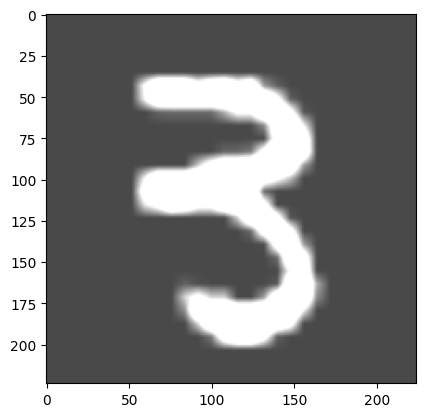

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision

# Function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#  Random batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Choose a random image from the batch
random_index = torch.randint(len(images), size=(1,)).item()
random_image = images[random_index]

# Display the image
imshow(torchvision.utils.make_grid(random_image))


In [116]:
modified_dim_random = random_image.unsqueeze(0)
prediction = vgg16(modified_dim_random.cuda())

In [117]:
# logits -> probabilities
probabilities = F.softmax(prediction, dim=1)

# Find the index with the highest probability
_, predicted_index = torch.max(probabilities, 1)

# Print the probabilities for each class
print("Probabilities: ", probabilities)

# Print the index with the highest probability
print("Highest probability index: ", predicted_index.item())


Probabilities:  tensor([[2.0720e-18, 9.4948e-16, 4.1159e-14, 1.0000e+00, 3.1161e-18, 3.8042e-12,
         5.6100e-19, 4.7868e-15, 5.9556e-14, 3.7736e-14]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Highest probability index:  3


## Adversarial image
Now let's do some adversarial updates to make that 3 pass for a 1

In [152]:
device = torch.device('cuda')
def adversarial_update(model, loss, images, labels, eps) :
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True

    outputs = model(images)

    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()

    attack_images = images - images.grad * .07
    attack_images = torch.clamp(attack_images, 0, 1)

    return attack_images


loss = nn.CrossEntropyLoss()
vgg16.eval()
target_class = torch.tensor([1], dtype=torch.long).to(torch.device('cuda'))

img = adversarial_update(vgg16, loss, modified_dim_random, target_class, 0.007)


for i in range(20):
  img = img.clone().detach().requires_grad_(True).to(torch.device('cuda'))
  img = adversarial_update(vgg16, loss, img, target_class, 0.007)

  prediction = vgg16(img.cuda())
  probabilities = F.softmax(prediction, dim=1)
  print(probabilities[0][1])




tensor(0.0030, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0235, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0436, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0635, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0843, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.1134, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.1477, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.1906, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.2508, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.3198, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.4042, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.4928, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.5646, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.6281, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.6853, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.7317, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.7693, device='cuda:0', grad_fn=<SelectBackward0

Probabilities:  tensor([[0.0018, 0.8493, 0.0537, 0.0109, 0.0126, 0.0354, 0.0028, 0.0276, 0.0011,
         0.0048]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Highest probability index:  1


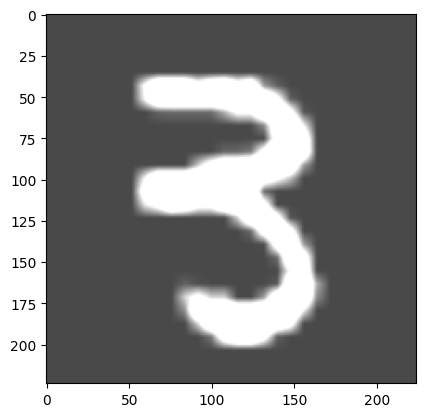

In [153]:
prediction = vgg16(img.cuda())
probabilities = F.softmax(prediction, dim=1)

# Find the index with the highest probability
_, predicted_index = torch.max(probabilities, 1)

# Print the probabilities for each class
print("Probabilities: ", probabilities)

# Print the index with the highest probability
print("Highest probability index: ", predicted_index.item())
imshow(torchvision.utils.make_grid(random_image))
